In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib
torch.set_default_dtype(torch.float64)

In [2]:
# ! nvidia-smi -q -g 0 -d UTILIZATION -l

In [17]:
! nvidia-smi 

Mon Apr 13 15:13:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:04:00.0 Off |                    0 |
| N/A   55C    P0   110W / 149W |  10512MiB / 11439MiB |     66%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   44C    P0   146W / 149W |   9464MiB / 11439MiB |     97%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Simple conv network

In [18]:
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor()])
BS = 10000
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS, shuffle=False)


In [40]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, 1)
        self.conv2 = nn.Conv2d(10, 10, 3, 1)
        self.conv3 = nn.Conv2d(10, 10, 3, 1)
        self.conv4 = nn.Conv2d(10, 10, 3, 1)

    def forward(self, x):
        x = self.conv1(x)                
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv4(x)
        x = F.max_pool2d(x, 2)

        output = F.log_softmax(x, dim=1).squeeze(2).squeeze(2)
        return output
torch.random.manual_seed(0)
model = Net().cuda()
w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print ("Total parameters",d)  

Total parameters 2830


# Let's compute the Hessian and spectrum for 1 batch


In [29]:
for batch_idx, (data, target) in enumerate(trainloader):
  break
data, target = data.double().cuda(), target.cuda()
output = model(data)
loss = F.nll_loss(output, target)  # The negative log likelihood loss.   https://pytorch.org/docs/stable/nn.functional.html#nll-loss
grad_f = torch.autograd.grad(loss, model.parameters(), create_graph=True)  # computation of gradient 



# Let's implement Trust-Region using Steihaug’s Method
-- This is the most widely used method for the approximate solution
of the trust-region subproblem

In [30]:
import os
import time
import datetime
import torch
torch.set_default_dtype(torch.float64)
torch.set_num_threads(1) #cpu num
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import csv
import random
import os
import itertools
import math
import numpy as np
import math
import torch.optim as optim
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from torch.nn.parameter import Parameter
from collections import OrderedDict
import sys


# stolen from Zheng Shi zhs310@lehigh.edu and Majid Jahani maj316@lehigh.edu
class TRCGOptimizer:
    def __init__(self,model,device,radius,cgopttol=1e-7,c0tr=0.2,c1tr=0.25,c2tr=0.75,t1tr=0.25,t2tr=2.0,radius_max=5.0,\
                 radius_initial=0.1):
        
        self.model = model
        self.device = device
        self.cgopttol = cgopttol
        self.c0tr = c0tr
        self.c1tr = c1tr
        self.c2tr = c2tr
        self.t1tr = t1tr
        self.t2tr = t2tr
        self.radius_max = radius_max
        self.radius_initial = radius_initial
        self.radius = radius
        self.cgmaxiter = 60
        
    def findroot(self,x,p):
        
        aa = 0.0
        bb = 0.0
        cc = 0.0
    
        for e in range(len(x)):
            aa += (p[e]*p[e]).sum()
            bb += (p[e]*x[e]).sum()
            cc += (x[e]*x[e]).sum()
        
        bb = bb*2.0
        cc = cc - self.radius**2
    
        alpha = (-2.0*cc)/(bb+(bb**2-(4.0*aa*cc)).sqrt())

        return alpha.data.item()
    
    
    def CGSolver(self,loss_grad,cnt_compute):
    
        cg_iter = 0 # iteration counter
        x0 = [] # define x_0 as a list
        for i in self.model.parameters():
            x0.append(torch.zeros(i.shape).to(self.device))
    
        r0 = [] # set initial residual to gradient
        p0 = [] # set initial conjugate direction to -r0
        self.cgopttol = 0.0
        
        for i in loss_grad:
            r0.append(i.data+0.0)     
            p0.append(0.0-i.data)
            self.cgopttol+=torch.norm(i.data)**2
        
        self.cgopttol = self.cgopttol.data.item()**0.5
        self.cgopttol = (min(0.5,self.cgopttol**0.5))*self.cgopttol
    
        cg_term = 0
        j = 0

        while 1:
            j+=1
    
            # if CG does not solve model within max allowable iterations
            if j > self.cgmaxiter:
                j=j-1
                p1 = x0
                print ('\n\nCG has issues !!!\n\n')
                break
            # hessian vector product
            loss_grad_direct = 0.0
            ind = 0
            for i in loss_grad:
                loss_grad_direct += (i*p0[ind]).sum()
                ind+=1
            Hp = torch.autograd.grad(loss_grad_direct,self.model.parameters(),retain_graph=True) # hessian-vector in tuple
            cnt_compute+=1
            
            pHp = 0.0 # quadratic term
            ind = 0
            for i in Hp:
                pHp += (p0[ind]*i).sum()
                ind+=1
    
            # if nonpositive curvature detected, go for the boundary of trust region
            if pHp.data.item() <= 0:
                tau = self.findroot(x0,p0)
                p1 = []
                for e in range(len(x0)):
                    p1.append(x0[e]+tau*p0[e])
                cg_term = 1
                break
            
            # if positive curvature
            # vector product
            rr0 = 0.0
            for i in r0:
                rr0 += (i*i).sum()
            
            # update alpha
            alpha = (rr0/pHp).data.item()
        
            x1 = []
            norm_x1 = 0.0
            for e in range(len(x0)):
                x1.append(x0[e]+alpha*p0[e])
                norm_x1 += torch.norm(x0[e]+alpha*p0[e])**2
            norm_x1 = norm_x1**0.5
            
            # if norm of the updated x1 > radius
            if norm_x1.data.item() >= self.radius:
                tau = self.findroot(x0,p0)
                p1 = []
                for e in range(len(x0)):
                    p1.append(x0[e]+tau*p0[e])
                cg_term = 2
                break
    
            # update residual
            r1 = []
            norm_r1 = 0.0
            for e in range(len(r0)):
                r1.append(r0[e]+alpha*Hp[e])
                norm_r1 += torch.norm(r0[e]+alpha*Hp[e])**2
            norm_r1 = norm_r1**0.5
    
            if norm_r1.data.item() < self.cgopttol:
                p1 = x1
                cg_term = 3
                break
    
            rr1 = 0.0
            for i in r1:
                rr1 += (i*i).sum()
    
            beta = (rr1/rr0).data.item()
    
            # update conjugate direction for next iterate
            p1 = []
            for e in range(len(r1)):
                p1.append(-r1[e]+beta*p0[e])
    
            p0 = p1
            x0 = x1
            r0 = r1
    

        cg_iter = j
        d = p1

        return d,cg_iter,cg_term,cnt_compute
    
    def step(self,loss,MSE,x_time_series,y_time_series):
        
        update = 2
    
        loss_grad = torch.autograd.grad(loss,self.model.parameters(),create_graph=True) 
        NormG = torch.sqrt(np.sum([(li.data*li.data).sum() for li in loss_grad])).data.item()
        ListG = [torch.sqrt((li.data*li.data).sum()) for li in loss_grad]
    
        cnt_compute=1
        
        # Conjugate Gradient Method
        d, cg_iter, cg_term, cnt_compute = self.CGSolver(loss_grad,cnt_compute)

        # current iterate 
        w0 = []
        for i in self.model.parameters():
            w0.append(i.data.cpu().numpy())
    
        # update solution
        ind = 0
        for i in self.model.parameters():
            i.data = torch.from_numpy(w0[ind]).to(self.device)+d[ind]
            ind+=1
    
        # MSE loss plus penalty term
        with torch.no_grad():
            Pred_new = self.model(x_time_series)
            loss_new = MSE(Pred_new,y_time_series)

        numerator = loss.data.item() - loss_new.data.item()

        # dHd
        Hd = 0.0
        loss_grad_direct = 0.0
        ind = 0
        for i in loss_grad:
            loss_grad_direct += (i*d[ind]).sum()
            ind+=1
        Hd = torch.autograd.grad(loss_grad_direct,self.model.parameters()) # hessian-vector in tuple
        dHd = 0.0 # quadratic term
        ind = 0
        for i in Hd:
            dHd += (d[ind]*i.data).sum()
            ind+=1

        gd = 0.0
        ind = 0
        for i in loss_grad:
            gd += (i.data*d[ind]).sum()
            ind+=1

        norm_d = 0.0
        for i in d:
            norm_d += torch.norm(i)**2
        norm_d = norm_d**0.5
        
        denominator = -gd.data.item() - 0.5*(dHd.data.item())

        # ratio
        rho = numerator/denominator

        if rho < self.c1tr: # shrink radius
            self.radius = self.t1tr*self.radius
            update = 0
        if rho > self.c2tr and np.abs(norm_d.data.item() - self.radius) < 1e-10: # enlarge radius
            self.radius = min(self.t2tr*self.radius,self.radius_max)
            update = 1
        # otherwise, radius remains the same
        
        if rho <= self.c0tr: # reject d
            update = 3
            ind = 0
            for i in self.model.parameters():
                i.data = torch.from_numpy(w0[ind]).to(self.device)
                ind+=1
    
#         return d, rho, update, cg_iter, cg_term, loss_grad, norm_d, numerator, denominator, w0
        return self.radius, cnt_compute, cg_iter
        

In [31]:
radius_initial = 1.0

trVal = []
trCost = []

optimizer = TRCGOptimizer(model,"cuda",radius_initial)

In [32]:
optimizer.cgmaxiter = 100
optimizer.cgopttol = 0.00001

In [33]:

for it in range(1000):
  output = model(data)
  loss = F.nll_loss(output, target)  # The negative log likelihood loss.   https://pytorch.org/docs/stable/nn.functional.html#nll-loss
  rad, cnt_compute, cgiter = optimizer.step(loss,F.nll_loss,data,target)  
  print (it, loss.item(), cgiter, rad, cnt_compute)
  trVal.append(loss.item())
  trCost.append(1+cgiter)

0 2.307827246867835 2 0.25 3
1 2.307827246867835 1 0.5 2
2 2.2977464121058238 1 0.5 2
3 2.280790717717757 2 0.5 3
4 2.253729417322934 2 1.0 3
5 2.1676991439892315 1 0.25 2
6 2.1676991439892315 1 0.5 2
7 2.026442701165602 1 1.0 2
8 1.593886553237378 2 0.25 3
9 1.593886553237378 2 0.25 3
10 1.5103390009312867 2 0.25 3
11 1.321569924616701 3 0.0625 4
12 1.321569924616701 2 0.125 3
13 1.2594892868451273 2 0.25 3
14 1.158238983751752 3 0.25 4
15 1.062138936902111 1 0.25 2
16 0.948839628808452 4 0.5 5
17 0.817533313653848 1 0.5 2
18 0.7650805086882071 5 1.0 6
19 0.6230340462897358 1 1.0 2
20 0.5803737693587018 2 1.0 3
21 0.5723395784590403 12 1.0 13
22 0.4523225241549234 1 1.0 2
23 0.42568430589541567 6 1.0 7
24 0.3799985632899768 1 1.0 2
25 0.3767703922007433 13 0.25 14
26 0.3767703922007433 9 0.5 10
27 0.34417908843531053 1 0.5 2
28 0.3410341082126502 10 1.0 11
29 0.30109782420053544 1 1.0 2
30 0.2992497978219501 14 0.25 15
31 0.2992497978219501 12 0.5 13
32 0.2709855549989939 6 0.5 7
33 0

In [34]:
output = model(data)
torch.sum(torch.abs(torch.argmax(output,1)-target)>0)

tensor(0, device='cuda:0')

In [26]:
26/7000, 116/10000

(0.0037142857142857142, 0.0116)

In [35]:
# torch.save(model.state_dict(), "./test_10000_0_10_10_10.pkl")

# model.load_state_dict(torch.load("./test_7000_33_5_10_10.pkl"))
# model


0.0116


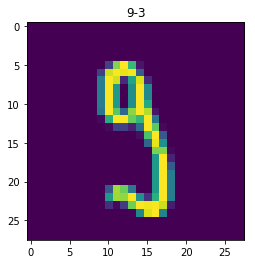

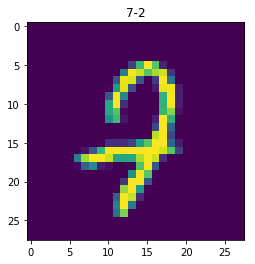

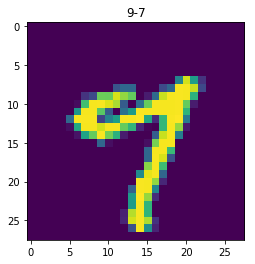

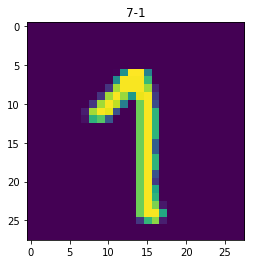

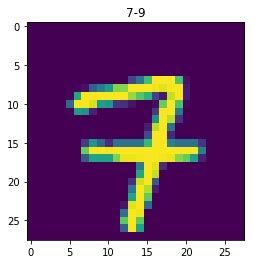

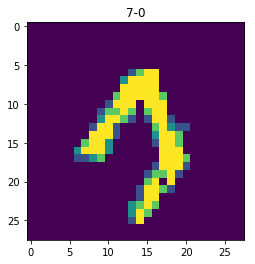

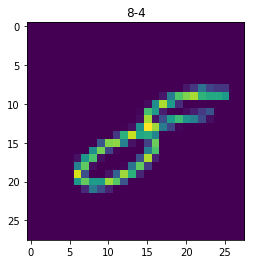

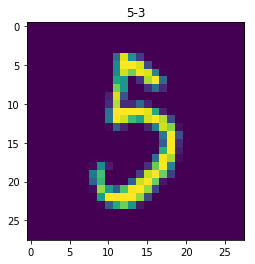

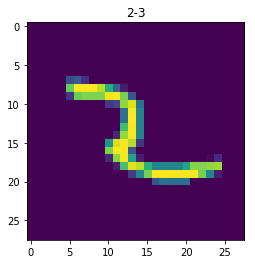

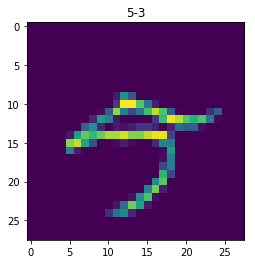

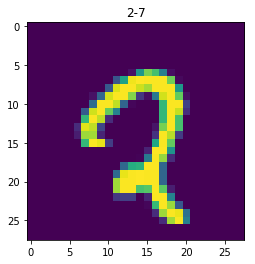

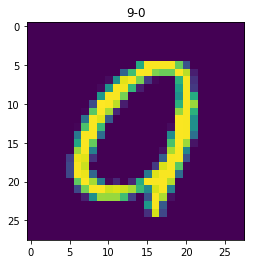

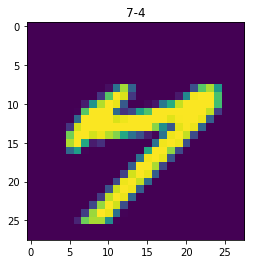

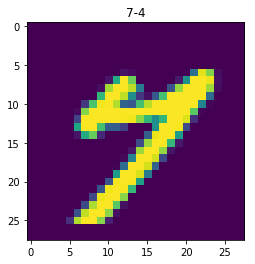

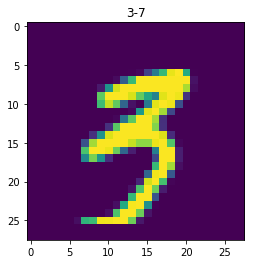

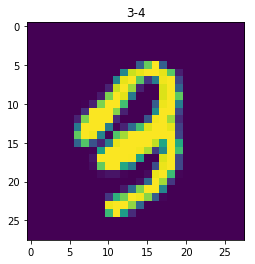

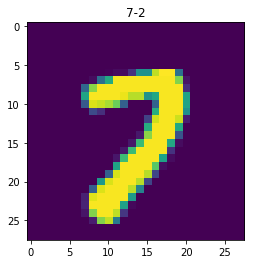

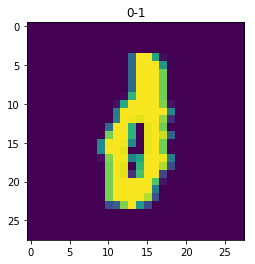

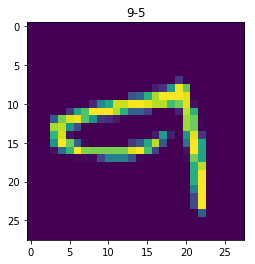

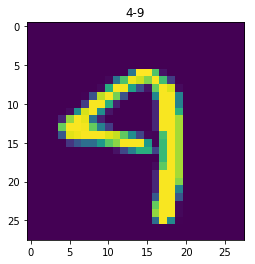

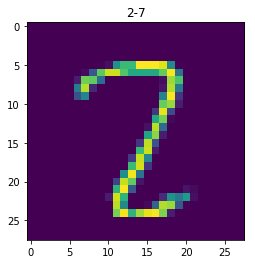

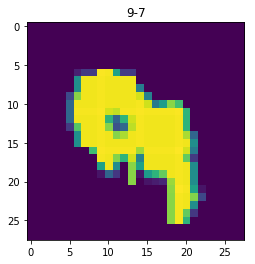

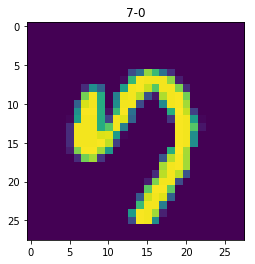

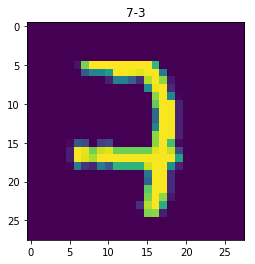

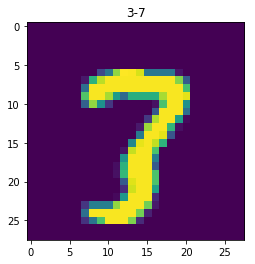

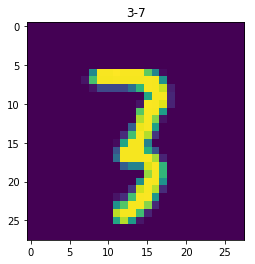

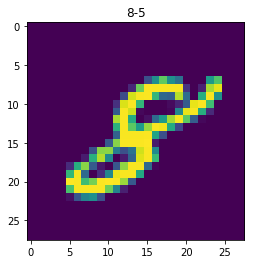

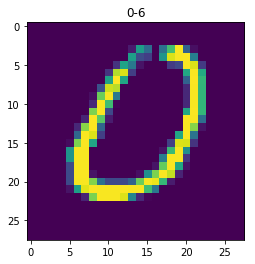

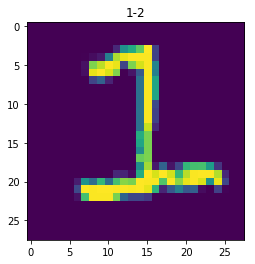

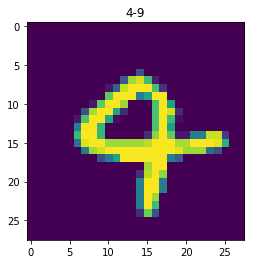

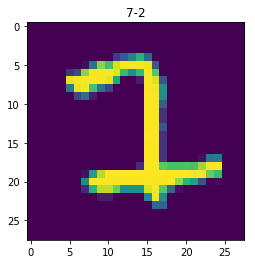

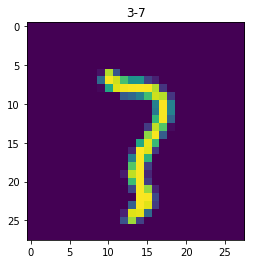

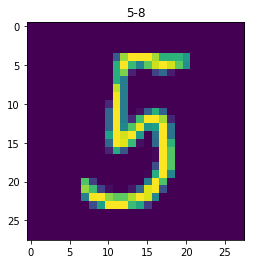

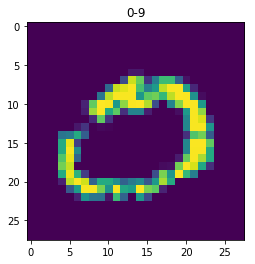

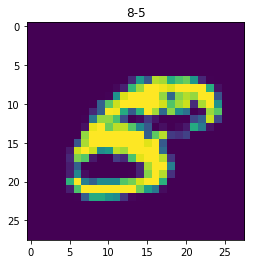

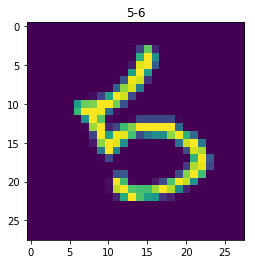

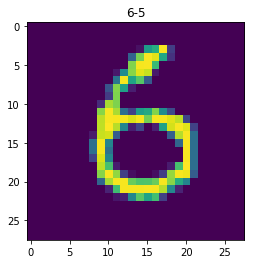

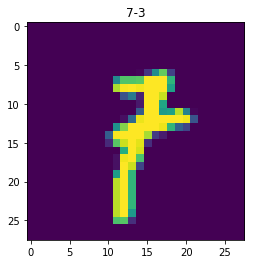

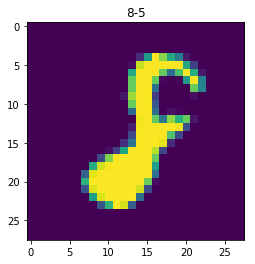

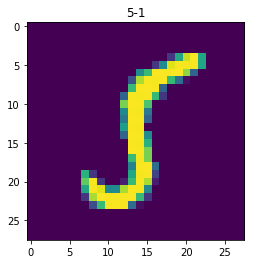

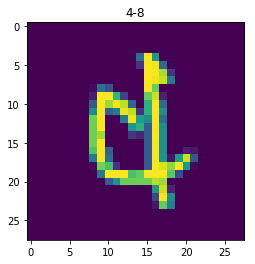

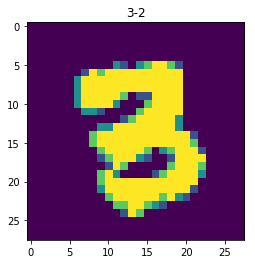

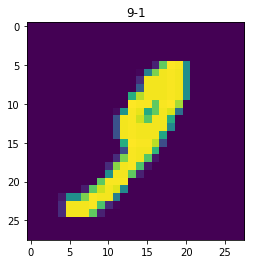

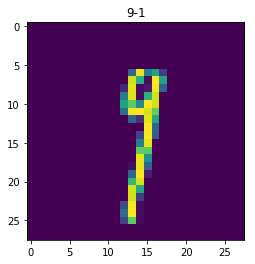

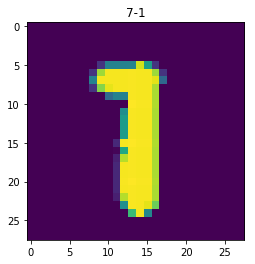

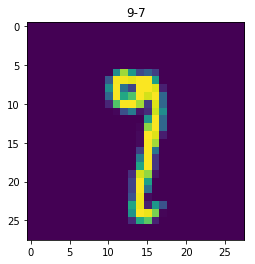

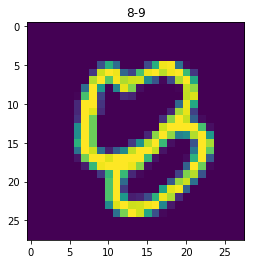

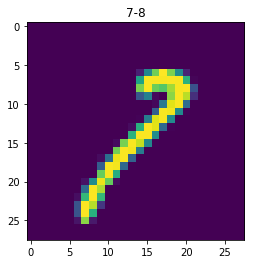

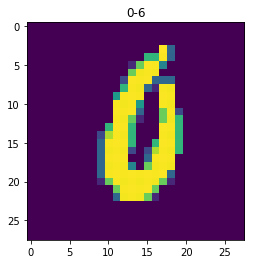

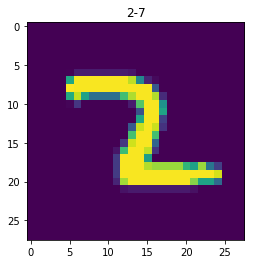

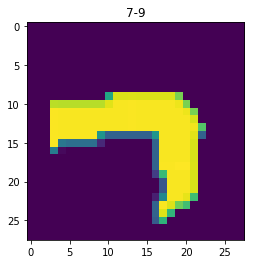

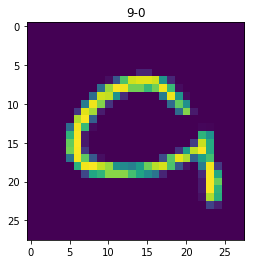

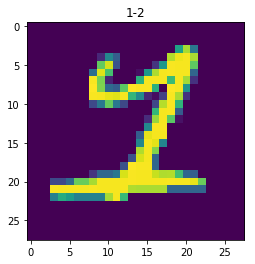

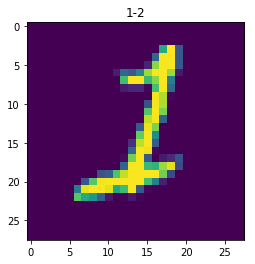

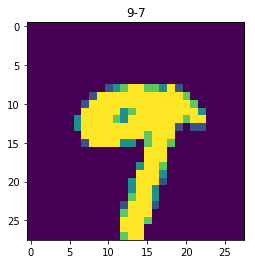

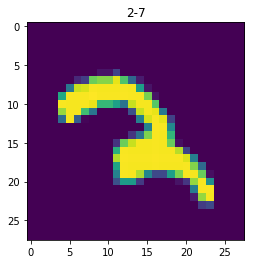

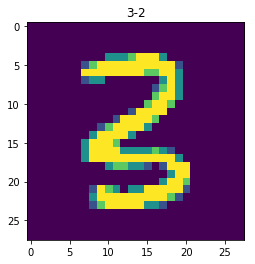

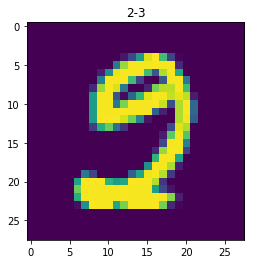

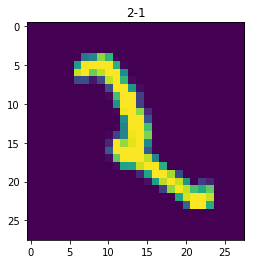

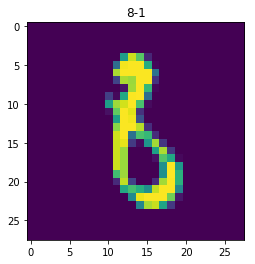

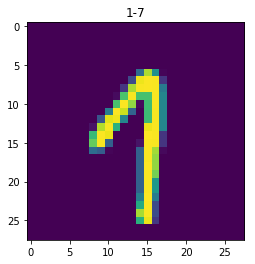

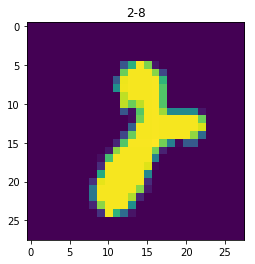

KeyboardInterrupt: 

In [27]:
output = model(data)
print (torch.sum(torch.abs(torch.argmax(output,1)-target)>0).item()/len(target))
# output- target
for i, v in enumerate(torch.abs(torch.argmax(output,1)-target)):
    if v != 0:
        plt.title(str(target[i].item())+"-"+str(torch.argmax(output[i]).item()))
        plt.imshow(data[i].cpu().data.numpy()[0])
        plt.show()




In [43]:
TE=[]
for dt,dl in testloader:
    output = model(dt.cuda().double())
    TE.append (torch.sum(torch.abs(torch.argmax(output,1)-dl.cuda())>0).item()/len(dl))
np.mean(TE)

0.048900000000000006

In [ ]:
output = model(data)
loss = F.nll_loss(output, target)  # The negative log likelihood loss.   https://pytorch.org/docs/stable/nn.functional.html#nll-loss
grad_f = torch.autograd.grad(loss, model.parameters(), create_graph=True)  # computation of gradient 
d = np.sum([w.numel() for w in model.parameters()])

Hessian = torch.zeros([d,d],device="cuda")
j = 0
for g in grad_f:
  g = g.view(-1)
  for i in range(g.numel()):
    Hv = torch.autograd.grad(g[i] , model.parameters(), create_graph=True)
    v = torch.cat([vi.reshape(-1) for vi in Hv]).detach()
    Hessian[:,j] = v 
    j+=1
HessianNP = Hessian.cpu().data.numpy()  
print (np.max(np.abs(HessianNP-HessianNP.T)))
S,U = np.linalg.eig(HessianNP)
snew = sorted(S+0.0)
plt.semilogy(snew,'b-')
plt.semilogy(-np.array(snew),'r-')


In [ ]:
np.real(snew)[0],np.real(snew)[-1]

In [ ]:
np.matmul(HessianNP,np.real(U[:,367]))/np.real(U[:,367])

In [ ]:
np.argmin(S)

{}

# ADAM

In [46]:

torch.random.manual_seed(0)
model = Net().cuda()

allSamples = [i for i in range(len(target))]
np.random.seed(0)

for lrv in [1e-5,1e-4,1e-3]:
    optimizer = torch.optim.Adam(model.parameters(), lr = lrv )
    hist=[]
    ABS = 50
    for epoch in range(1000):
        np.random.shuffle(allSamples)
        for it in range(len(target)//ABS):
            output = model(data[allSamples[it*ABS:(it+1)*ABS]])
            loss = F.nll_loss(output, target[it*ABS:(it+1)*ABS])  # The negative log likelihood loss.   https://pytorch.org/docs/stable/nn.functional.html#nll-loss            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch%10 == 9:
            with torch.no_grad():
                output = model(data)
                val = (epoch, F.nll_loss(output, target).item() , torch.sum(torch.abs(torch.argmax(output,1)-target)>0).item()/len(target))
                hist.append(val)
                print(lrv,hist[-1])
    adam[lrv] = hist
    


1e-05 (9, 2.3014490776596204, 0.8978571428571429)
1e-05 (19, 2.3008382478958906, 0.888)
1e-05 (29, 2.3005554599658304, 0.888)
1e-05 (39, 2.300516752824776, 0.888)
1e-05 (49, 2.3005906951998596, 0.888)
1e-05 (59, 2.3006479848692547, 0.888)
1e-05 (69, 2.300697606795476, 0.888)
1e-05 (79, 2.3006797353065114, 0.888)
1e-05 (89, 2.3006734354105403, 0.888)
1e-05 (99, 2.300658909744323, 0.888)
1e-05 (109, 2.300632539515604, 0.888)
1e-05 (119, 2.3006530939739287, 0.888)
1e-05 (129, 2.30066181426594, 0.888)
1e-05 (139, 2.3006582457893154, 0.888)
1e-05 (149, 2.3006214328385446, 0.888)
1e-05 (159, 2.300580087506448, 0.888)
1e-05 (169, 2.3005879753181677, 0.888)
1e-05 (179, 2.3005939568365643, 0.888)
1e-05 (189, 2.3005983112604325, 0.888)
1e-05 (199, 2.300585157752046, 0.888)
1e-05 (209, 2.300608931656049, 0.888)
1e-05 (219, 2.300617705828436, 0.888)
1e-05 (229, 2.300621092951675, 0.888)
1e-05 (239, 2.3006074726154395, 0.888)
1e-05 (249, 2.3005624729729077, 0.888)
1e-05 (259, 2.300528544346145, 0.8

In [33]:
1e-3

0.001

In [ ]:
trVal


In [56]:
exit(0)